# HANDWRITTEN DIGITS CLASSIFIER

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [76]:
tf.__version__

'1.6.0'

### NEURAL NETWORK CONFIGURATION

In [77]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [78]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [79]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [80]:
data.test.cls = np.argmax(data.test.labels, axis=1)


### Data Dimensions


In [81]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_channels = 1

num_classes = 10

### Helper function for plotting

In [82]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(1, 1)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

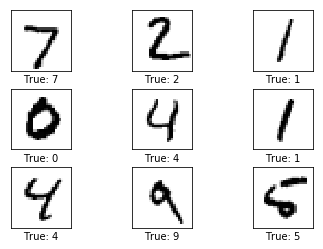

In [83]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

### Helper functions to create variables

In [84]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [85]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper function to create Convolutional Layer

In [86]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

### Helper function to flatten a layer

In [87]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper function to create a fully connencted layer

In [88]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder Variables

In [89]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [90]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [91]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [92]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolution Layer 1

In [93]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [94]:
weights_conv1, layer_conv1

(<tf.Variable 'Variable_8:0' shape=(5, 5, 1, 16) dtype=float32_ref>,
 <tf.Tensor 'Relu_3:0' shape=(?, 14, 14, 16) dtype=float32>)

### Convolutional Layer 2    

In [95]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [96]:
weights_conv2, layer_conv2

(<tf.Variable 'Variable_10:0' shape=(5, 5, 16, 36) dtype=float32_ref>,
 <tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>)

### Flatten layer

In [97]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [98]:
layer_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 1764) dtype=float32>

### Fully Connected layer


In [99]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [100]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

### Fully Connected layer

In [101]:
layer_fc2 = new_fc_layer(input = layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. ReLU is not used in this layer. It is the final layer

### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one.

In [102]:
y_pred = tf.nn.softmax(layer_fc2)

In [103]:
y_pred_cls = tf.argmax(y_pred, axis=1)
#The final output number is the largest element of y_pred

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

In [104]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [105]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.


In [106]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [107]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [108]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
saver = tf.train.Saver()

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

## TensorFlow Run

### Create TensorFlow session


In [109]:
session = tf.Session()

### Initialize variables

In [110]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

In [111]:
train_batch_size = 64

In [112]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [113]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [115]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False):
                        

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        # The ending index for the next batch is j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

   

In [117]:
optimize(num_iterations=1000)

Optimization Iteration:    101, Training Accuracy:  78.1%
Optimization Iteration:    201, Training Accuracy:  82.8%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  92.2%
Optimization Iteration:   1001, Training Accuracy: 100.0%
Time usage: 0:01:41


Accuracy on Test-Set: 93.7% (9369 / 10000)
Example errors:


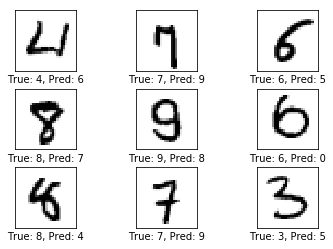

In [118]:
print_test_accuracy(show_example_errors=True)


In [120]:
optimize(num_iterations = 10000)

Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  89.1%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  95.3%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization Iteration:   2701, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.7% (9873 / 10000)
Example errors:


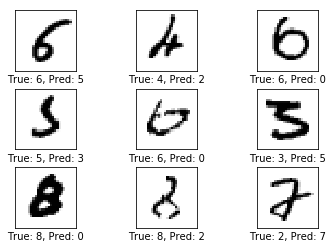

In [121]:
print_test_accuracy(show_example_errors=True)

In [170]:
def predict(image):
    predictions = session.run(y_pred_cls, feed_dict={x:image})
    return predictions[0]

In [172]:
predict(data.test.images[0:1])

7